# Transfer learning for video classification with MoViNet

https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet

## Imports

In [6]:
!pip install tensorflow==2.11

  Using cached tensorflow-2.11.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.10.0
    Uninstalling tensorflow-2.10.0:
      Successfully uninstalled tensorflow-2.10.0


In [7]:
import tensorflow as tf

ImportError: cannot import name 'experimental_functions_run_eagerly' from 'tensorflow.python.eager.def_function' (C:\Users\BEE Team\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\eager\def_function.py)

In [ ]:
!pip show tensorflow

In [9]:
!pip show keras

Name: keras
Version: 2.11.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\public\new\envs\tensorflowraul\lib\site-packages
Requires: 
Required-by: tensorflow-intel


In [47]:
#!pip install tf-models-official

In [2]:
#!pip install tensorflow==2.11

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

from pathlib import Path

#import tensorflow_hub as hub
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
#from official.projects.movinet.modeling import movinet
#from official.projects.movinet.modeling import movinet_model

ImportError: cannot import name 'experimental_functions_run_eagerly' from 'tensorflow.python.eager.def_function' (C:\Users\BEE Team\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\eager\def_function.py)

In [ ]:
# Set the seed for Python's random number generator
random.seed(1999)

# Set the seed for NumPy's random number generator
np.random.seed(1999)

# Set the seed for TensorFlow's random number generator
tf.random.set_seed(1999)

## Classes:

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

## Functions

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 60):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

In [4]:
### added model to the input
def get_actual_predicted_labels(dataset, model): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [5]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [6]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

# Data with everything

**6 classes:**
+ Background
+ Intcleaner
+ intclient
+ TS
+ Jolt
+ Chase

Path: *Sep_Clips*

In [7]:
n_frames = 10
batch_size = 1

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

NameError: name 'tf' is not defined

In [8]:
# Create the training set
train_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/train'), n_frames, training=True),
                                          output_signature = output_signature)
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/val'), n_frames),
                                        output_signature = output_signature)
# Create the test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/test'), n_frames),
                                         output_signature = output_signature)

NameError: name 'tf' is not defined

In [66]:
# Batch the data
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [67]:
model = keras.Model(input, x)

NameError: name 'x' is not defined

In [27]:
frames, label = next(iter(train_ds))
model.build(frames)

NameError: name 'model' is not defined

In [24]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [26]:
history = model.fit(x = train_ds, epochs = 50, validation_data = val_ds)

Epoch 1/50
117/117 [==============================] - 242s 2s/step - loss: 1.7395 - accuracy: 0.4359 - val_loss: 1.8902 - val_accuracy: 0.2045
Epoch 2/50
117/117 [==============================] - 234s 2s/step - loss: 1.4520 - accuracy: 0.3846 - val_loss: 1.6168 - val_accuracy: 0.3409
Epoch 3/50
117/117 [==============================] - 234s 2s/step - loss: 1.3896 - accuracy: 0.4701 - val_loss: 1.8056 - val_accuracy: 0.3409
Epoch 4/50
117/117 [==============================] - 234s 2s/step - loss: 1.4349 - accuracy: 0.3761 - val_loss: 1.4758 - val_accuracy: 0.3409
Epoch 5/50
117/117 [==============================] - 234s 2s/step - loss: 1.3494 - accuracy: 0.4017 - val_loss: 1.6323 - val_accuracy: 0.3409
Epoch 6/50
117/117 [==============================] - 234s 2s/step - loss: 1.3248 - accuracy: 0.4188 - val_loss: 1.9589 - val_accuracy: 0.3409
Epoch 7/50
117/117 [==============================] - 234s 2s/step - loss: 1.3312 - accuracy: 0.4359 - val_loss: 1.9257 - val_accuracy: 0.3409

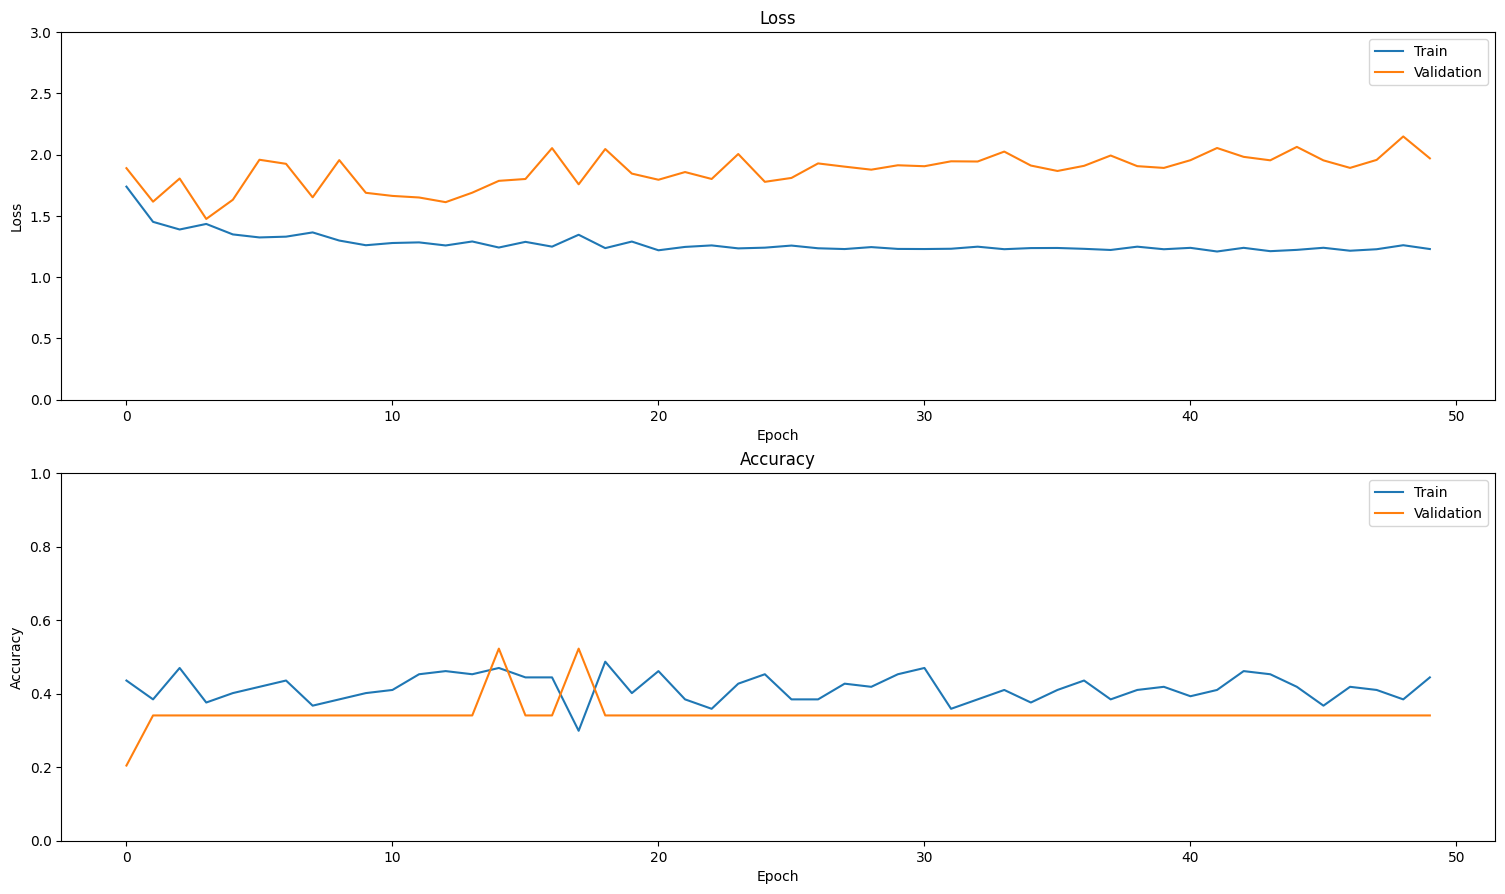

In [27]:
plot_history(history)

In [28]:
model.evaluate(test_ds, return_dict=True)

38/38 [==============================] - 35s 905ms/step - loss: 2.6353 - accuracy: 0.0000e+00


{'loss': 2.6353373527526855, 'accuracy': 0.0}

In [29]:
fg = FrameGenerator(Path('Summarys_labels/Sep_Clips/train'), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

117/117 [==============================] - 124s 1s/step


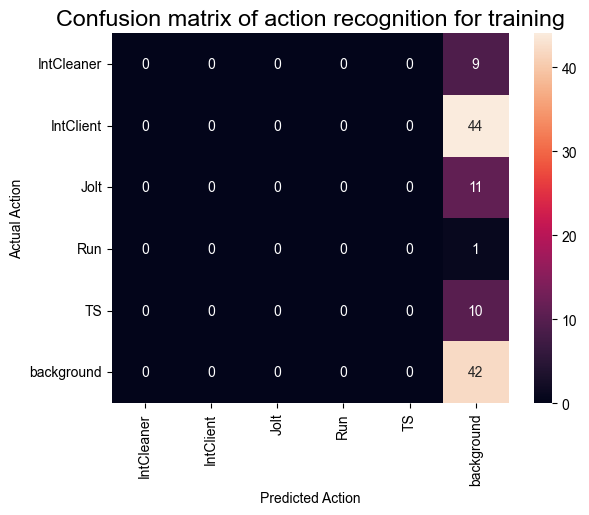

In [30]:
actual, predicted = get_actual_predicted_labels(train_ds, model)
plot_confusion_matrix(actual, predicted, labels, 'training')

38/38 [==============================] - 35s 904ms/step


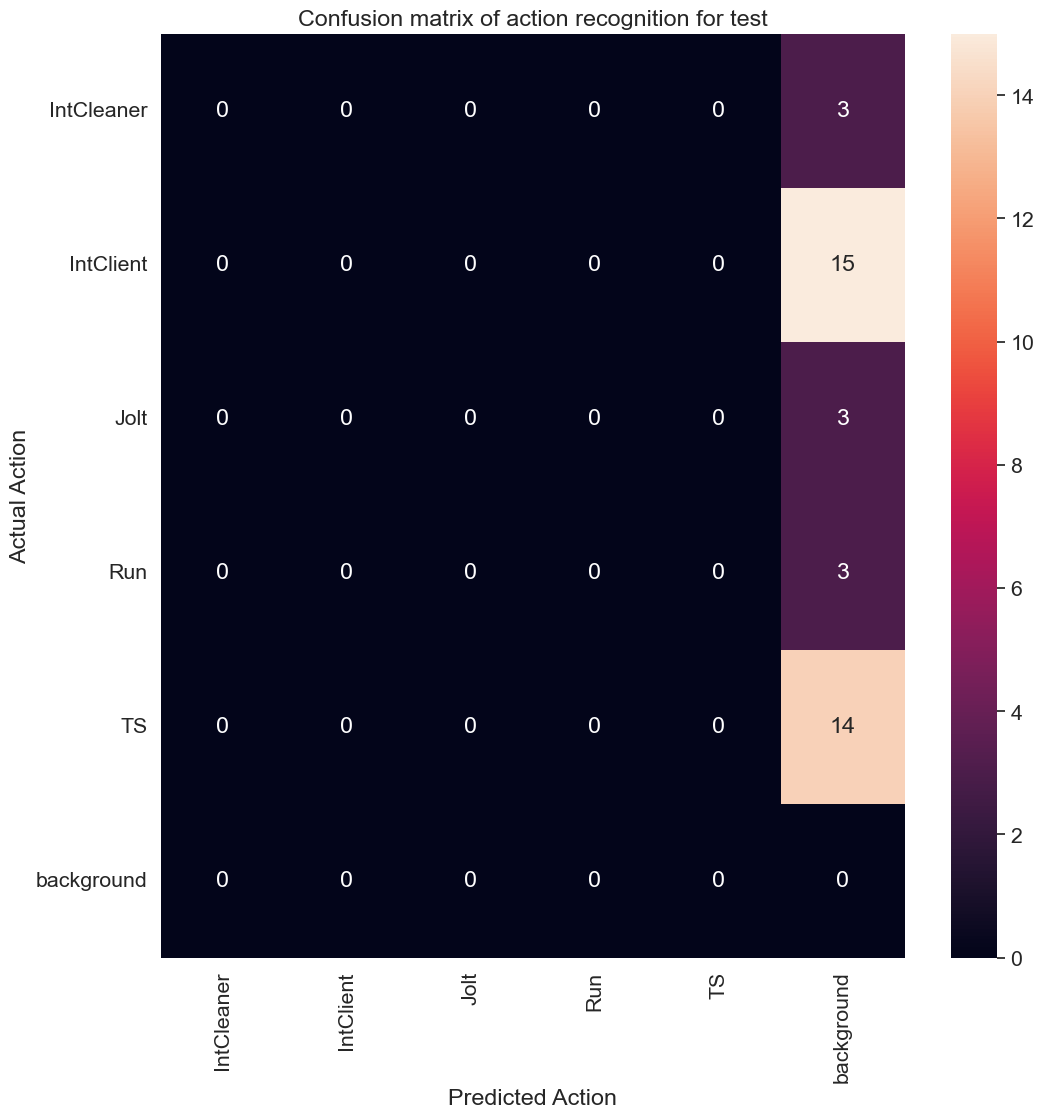

In [31]:
actual, predicted = get_actual_predicted_labels(test_ds, model)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [32]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

C:\Users\BEE Team\AppData\Local\Temp\ipykernel_13864\3092751621.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision
C:\Users\BEE Team\AppData\Local\Temp\ipykernel_13864\3092751621.py:27: RuntimeWarning: invalid value encountered in long_scalars
  recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall


In [33]:
precision

{'IntCleaner': nan,
 'IntClient': nan,
 'Jolt': nan,
 'Run': nan,
 'TS': nan,
 'background': 0.0}

In [34]:
recall

{'IntCleaner': 0.0,
 'IntClient': 0.0,
 'Jolt': 0.0,
 'Run': 0.0,
 'TS': 0.0,
 'background': nan}

In [ ]:
# Data with everything

**6 classes:**
+ Background
+ Intcleaner
+ intclient
+ TS
+ Jolt
+ Chase

Path: *Sep_Clips*

n_frames = 10
batch_size = 1

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

# Create the training set
train_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/train'), n_frames, training=True),
                                          output_signature = output_signature)
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/val'), n_frames),
                                        output_signature = output_signature)
# Create the test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/test'), n_frames),
                                         output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

model = keras.Model(input, x)

frames, label = next(iter(train_ds))
model.build(frames)

# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

history = model.fit(x = train_ds, epochs = 50, validation_data = val_ds)

plot_history(history)

model.evaluate(test_ds, return_dict=True)

fg = FrameGenerator(Path('Summarys_labels/Sep_Clips/train'), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(train_ds, model)
plot_confusion_matrix(actual, predicted, labels, 'training')

actual, predicted = get_actual_predicted_labels(test_ds, model)
plot_confusion_matrix(actual, predicted, labels, 'test')

precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

precision

recall